# 文件分類

主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。

## 分析目標
+ 資料內容：
    + 資料來源：壹蘋新聞網 (蘋果日報)
    + 版別：娛樂時尚、政治、國際  
    + 資料時間: 2022年 3月 ~ 4月

* 分析主題：將壹蘋新聞網三個版別的文章合起來，訓練模型能預測新聞版別，再用分類模型進行文件的版別分類。

* 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他家新聞文章的版別

## 1. 套件說明

- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [8]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

Text(0.5, 1.0, '聲量圖')

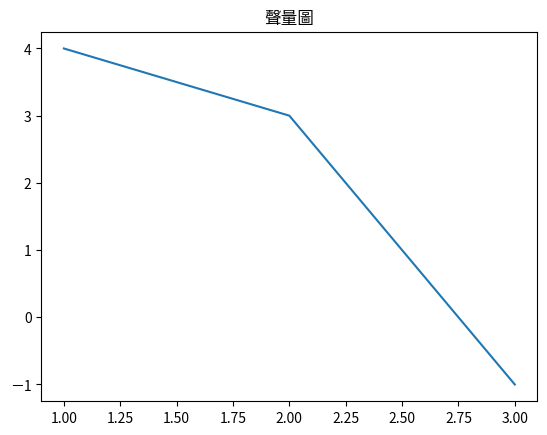

In [9]:
# from matplotlib import font_manager
# font_set = {f.name for f in font_manager.fontManager.ttflist}
from matplotlib.font_manager import fontManager
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
plt.rc('font', family='Taipei Sans TC Beta')
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
# plt.rcParams['font.family'] = 'AR PL UMing CN'
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

## 2. 文字前處理
`apple_data.csv`裡面包含了要分析的 udn 新聞資料。首先我們先看文集的基本資料，並做文集前處理。

In [10]:
udn = pd.read_csv("raw_data/apple_data.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,女團HUR熱舞秀辣腿 師弟VERA尬場香味撲鼻,2023-03-01 16:31:00,娛樂時尚,https://tw.nextapple.com/entertainment/2023030...,【記者林丞偉／台北報導】新世代唱跳女團「HUR」由利善榛、裴頡、C.Holly、連穎、巴倫⽉...,appleDaily
1,2,這個貼身教練讓「運動控」超放心 G-SHOCK新智慧錶有感升級還很輕,2023-03-01 22:57:00,娛樂時尚,https://tw.nextapple.com/entertainment/2023030...,【記者邱瓈瑩／台北報導】日本鐘錶品牌卡西歐（CASIO）繼日前宣布韓國女團ITZY成為旗下耐...,appleDaily
2,3,最想被翻拍的BL小說《奇蹟》開鏡 謝承均與亮哲親密關係不藏了,2023-03-01 19:17:00,娛樂時尚,https://tw.nextapple.com/entertainment/2023030...,【記者趙大智／台北報導】八大BL劇集《奇蹟》今日開鏡，在《俗女養成記》2季傳神演出同志弟弟的...,appleDaily


In [11]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


number of posts: 7981
date range: ('2023-03-01 00:03:00', '2023-04-29 23:36:00')
category: 
artCatagory
娛樂時尚    3264
國際      2678
政治      2039
Name: count, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [12]:
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,女團熱舞秀辣腿師弟尬場香味撲鼻,2023-03-01 16:31:00,娛樂時尚,https://tw.nextapple.com/entertainment/2023030...,記者林丞偉台北報導新世代唱跳女團由利善榛裴頡連穎巴倫席淇組成適逢出道年前夕在台北三創舉辦首場...,appleDaily
1,2,這個貼身教練讓運動控超放心新智慧錶有感升級還很輕,2023-03-01 22:57:00,娛樂時尚,https://tw.nextapple.com/entertainment/2023030...,記者邱瓈瑩台北報導日本鐘錶品牌卡西歐繼日前宣布韓國女團成為旗下耐衝擊腕錶品牌大使藉此宣告加緊...,appleDaily
2,3,最想被翻拍的小說奇蹟開鏡謝承均與亮哲親密關係不藏了,2023-03-01 19:17:00,娛樂時尚,https://tw.nextapple.com/entertainment/2023030...,記者趙大智台北報導八大劇集奇蹟今日開鏡在俗女養成記季傳神演出同志弟弟的宋偉恩這次擺脫過往角色...,appleDaily


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [13]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,女團熱舞秀辣腿師弟尬場香味撲鼻記者林丞偉台北報導新世代唱跳女團由利善榛裴頡連穎巴倫席淇組成適...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚
1,這個貼身教練讓運動控超放心新智慧錶有感升級還很輕記者邱瓈瑩台北報導日本鐘錶品牌卡西歐繼日前宣...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚
2,最想被翻拍的小說奇蹟開鏡謝承均與亮哲親密關係不藏了記者趙大智台北報導八大劇集奇蹟今日開鏡在俗...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚
3,舒淇新任全球代言人霸氣外露月這張美腿照就藏端倪記者張家玲台北報導月的第一天迎來了明媚的好天氣...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚
4,曲艾玲搶醫生飯碗被封曲醫師每天只睡小時結果出爐記者葉文正台北報導民視醫學大聯盟帶大家探討哪些...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚


In [14]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")

total docs: 7981


### 2.2 斷詞

In [15]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [16]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [17]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from c:\Users\user\Desktop\week12\dict\dict.txt.big ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u5a8781e24e2661767a7c154318fe7d46.cache
Loading model cost 1.119 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,女團熱舞秀辣腿師弟尬場香味撲鼻記者林丞偉台北報導新世代唱跳女團由利善榛裴頡連穎巴倫席淇組成適...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,女團 熱舞 秀辣腿 師弟 香味撲鼻 記者 林丞偉 台北 報導 世代 女團 由利善 裴頡連穎 ...
1,這個貼身教練讓運動控超放心新智慧錶有感升級還很輕記者邱瓈瑩台北報導日本鐘錶品牌卡西歐繼日前宣...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,貼身 教練 運動 控超 放心 智慧 有感 升級 還很輕 記者 台北 報導 日本 鐘錶 品牌 ...
2,最想被翻拍的小說奇蹟開鏡謝承均與亮哲親密關係不藏了記者趙大智台北報導八大劇集奇蹟今日開鏡在俗...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,最想 翻拍 小說 奇蹟 開鏡 謝承均 親密關係 不藏 記者 大智 台北 報導 八大 劇集 奇...
3,舒淇新任全球代言人霸氣外露月這張美腿照就藏端倪記者張家玲台北報導月的第一天迎來了明媚的好天氣...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,舒淇 新任 全球 代言人 霸氣 外露 這張 美腿 端倪 記者 張家 台北 報導 第一天 迎來...
4,曲艾玲搶醫生飯碗被封曲醫師每天只睡小時結果出爐記者葉文正台北報導民視醫學大聯盟帶大家探討哪些...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,曲艾玲 醫生 飯碗 封曲 醫師 每天 小時 出爐 記者 葉文正 台北 報導 民視 醫學 聯盟...


### 2.3 資料集基本檢視
檢視資料內容

In [18]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


total posts: 7981
category: 
artCatagory
娛樂時尚    3264
國際      2678
政治      2039
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [19]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

7856    馬英九 遭度 矮化 台北 領袖 趙天麟 建議 別去 記者 袁詩羽 台北 報導 總統 馬英九 ...
3756    櫻花 參加 慶典 當街 圍攻 性騷 女星 聲援 立即 逮捕 這群 色狼 劉育良 綜合 報導 ...
7553    九二 共識 成不了 大選 主牌 最新 民調 半數 台灣 贊同 記者 袁詩羽 台北 報導 九二...
7295    詐騙 猖獗 內政部 推打 綱領 林右昌將 提高 提供 帳戶 刑責 記者 袁詩羽 台北 報導 ...
2544    男星 兼差 計程車 客人 質疑 繞路 打負 評照 導航 委曲 車資 清白 宛如 綜合 報導 ...
Name: words, dtype: object
7856      政治
3756      國際
7553      政治
7295      政治
2544    娛樂時尚
Name: artCatagory, dtype: object


In [20]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
娛樂時尚    40.897131
國際      33.554692
政治      25.548177
Name: proportion, dtype: float64

train percentage :
artCatagory
娛樂時尚    41.281776
國際      32.957393
政治      25.760831
Name: proportion, dtype: float64

test percentage :
artCatagory
娛樂時尚    40.000000
國際      34.947808
政治      25.052192
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)

在這裡我們用簡單的四個中文句子，建立一個 DTM，在這裡我們利用 `CountVectorizer` 計算出不同句子的詞頻，再轉換成DTM。DTM裡面每個row代表一個句子，每個column代表一個詞出現的次數。

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [21]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [22]:
X_train.head()

7856    馬英九 遭度 矮化 台北 領袖 趙天麟 建議 別去 記者 袁詩羽 台北 報導 總統 馬英九 ...
3756    櫻花 參加 慶典 當街 圍攻 性騷 女星 聲援 立即 逮捕 這群 色狼 劉育良 綜合 報導 ...
7553    九二 共識 成不了 大選 主牌 最新 民調 半數 台灣 贊同 記者 袁詩羽 台北 報導 九二...
7295    詐騙 猖獗 內政部 推打 綱領 林右昌將 提高 提供 帳戶 刑責 記者 袁詩羽 台北 報導 ...
2544    男星 兼差 計程車 客人 質疑 繞路 打負 評照 導航 委曲 車資 清白 宛如 綜合 報導 ...
Name: words, dtype: object

In [23]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<5586x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 320761 stored elements in Compressed Sparse Row format>

In [24]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])


['一下' '一些' '一位' '一同' '一名' '一場' '一天' '一定' '一家' '一年']


In [26]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'馬英九': 987, '台北': 206, '領袖': 972, '建議': 382, '記者': 821, '袁詩羽': 800, '報導': 271, '總統': 747, '舉辦': 778, '經濟': 733, '外交部': 276, '抗議': 444, '對此': 342, '民進黨': 580, '立委': 707, '表示': 798, '努力': 168, '台灣': 211, '現在': 628, '變成': 851, '領導人': 971, '呼籲': 226, '外界': 279, '質疑': 859, '溝通': 597, '一度': 10, '最新': 528, '出席': 140, '辦公室': 878, '顯示': 975, '中共': 32, '尊重': 337, '不斷': 28, '訪中': 823, '做出': 106, '許多': 827, '有點': 538, '利益': 151, '並未': 31, '回應': 242, '自我': 771, '指出': 451, '訊息': 818, '曝光': 520, '曾經': 523, '發文': 661, '提醒': 470, '組織': 727, '透過': 884, '國際': 255, '方式': 499, '當時': 651, '外交': 275, '單位': 235, '對方': 341, '會議': 534, '接受': 457, '參加': 192, '應該': 418, '過去': 904, '依舊': 95, '中國': 33, '真的': 683, '身分': 869, '爆料': 613, '網址': 741, '信箱': 103, '下載': 23, '壹蘋': 274, '新聞網': 497, '追蹤': 883, '女星': 294, '立即': 705, '逮捕': 898, '劉育良': 161, '綜合': 737, '印度': 182, '舉行': 777, '活動': 590, '一名': 4, '日本': 504, '女生': 295, '遭到': 911, '男子': 642, '影片': 391, '引發': 383, '女性': 293, '媒體': 307, '這次': 891, '當天': 648, '發生': 663,

1

In [27]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)


(5586, 1000)
(2395, 1000)


In [28]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
clf.classes_

array(['國際', '娛樂時尚', '政治'], dtype=object)

In [30]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['政治' '國際' '娛樂時尚' '國際' '政治' '娛樂時尚' '娛樂時尚' '國際' '國際' '國際']


In [31]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(2395, 3)


array([8.09619898e-06, 6.94918100e-06, 9.99984955e-01])

In [32]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.96      0.96      0.96       837
        娛樂時尚       0.97      0.97      0.97       958
          政治       0.96      0.95      0.96       600

    accuracy                           0.96      2395
   macro avg       0.96      0.96      0.96      2395
weighted avg       0.96      0.96      0.96      2395



In [33]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[805,  17,  15],
       [ 19, 932,   7],
       [ 16,  11, 573]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '國際'), Text(0, 1.5, '娛樂時尚'), Text(0, 2.5, '政治')])

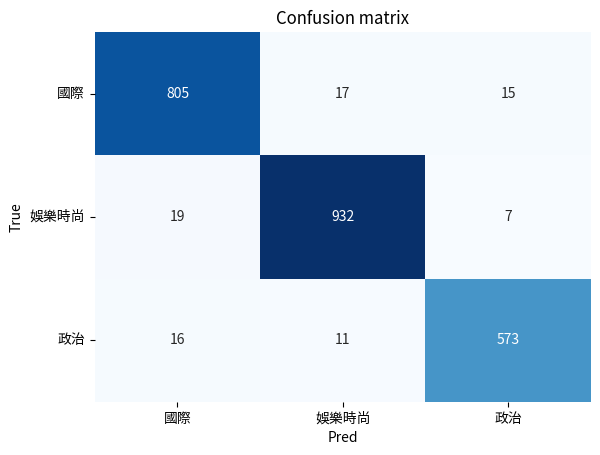

In [34]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [35]:
# one-hot encoding
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
print(y_onehot_test.shape)  # (n_samples, n_classes)
y_onehot_test[0,:]

(2395, 3)


array([0, 0, 1])

In [36]:
y_test.iloc[0]

'政治'

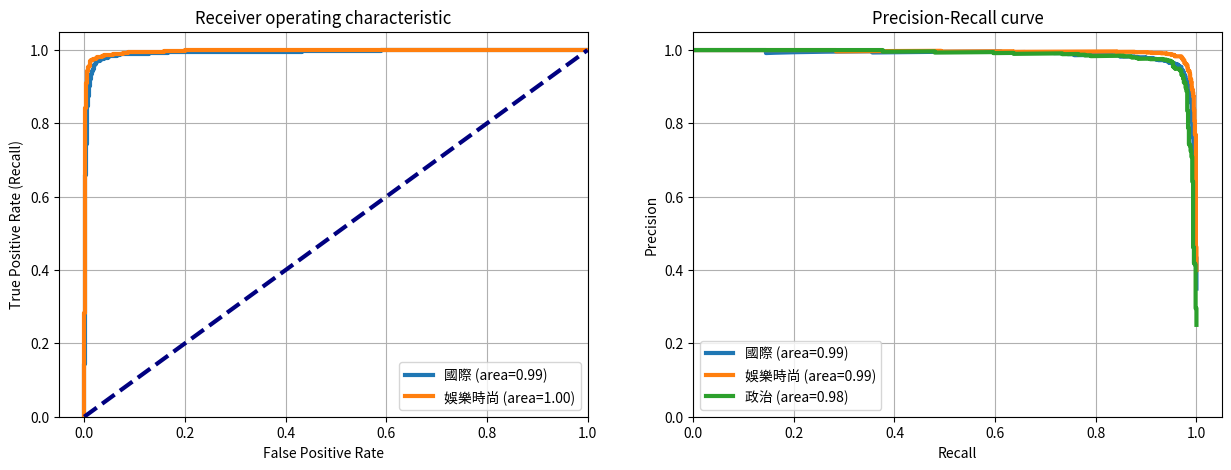

In [37]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)-1):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()

### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [38]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05177781, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01371349, 0.        ,
       0.        , 0.        , 0.        , 0.08710278, 0.        ,
       0.        , 0.05430783, 0.10312383, 0.05975039, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [39]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.96      0.96      0.96       837
        娛樂時尚       0.97      0.98      0.97       958
          政治       0.96      0.95      0.96       600

    accuracy                           0.96      2395
   macro avg       0.96      0.96      0.96      2395
weighted avg       0.96      0.96      0.96      2395



效果一樣也是不錯，可能因為三格新聞版別本來就有很大的差異，用字遣詞會不同。

### 3.5 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

In [40]:
clf = LogisticRegression()
vec_train = CountVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.32802033, 0.3174727 , 0.30076647, 0.32416511, 0.31715369]),
 'score_time': array([0.02194357, 0.01891494, 0.01792502, 0.01991487, 0.0189445 ]),
 'test_f1_macro': array([0.95366996, 0.96574821, 0.96324218, 0.96994329, 0.96988215]),
 'test_precision_macro': array([0.95339002, 0.96771708, 0.96611252, 0.97083583, 0.97066325]),
 'test_recall_macro': array([0.9540357 , 0.96399047, 0.96080697, 0.96916044, 0.96915535])}


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [41]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

              precision    recall  f1-score   support

          國際       0.96      0.96      0.96      1841
        娛樂時尚       0.97      0.98      0.98      2306
          政治       0.97      0.95      0.96      1439

    accuracy                           0.97      5586
   macro avg       0.97      0.96      0.96      5586
weighted avg       0.97      0.97      0.97      5586



c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

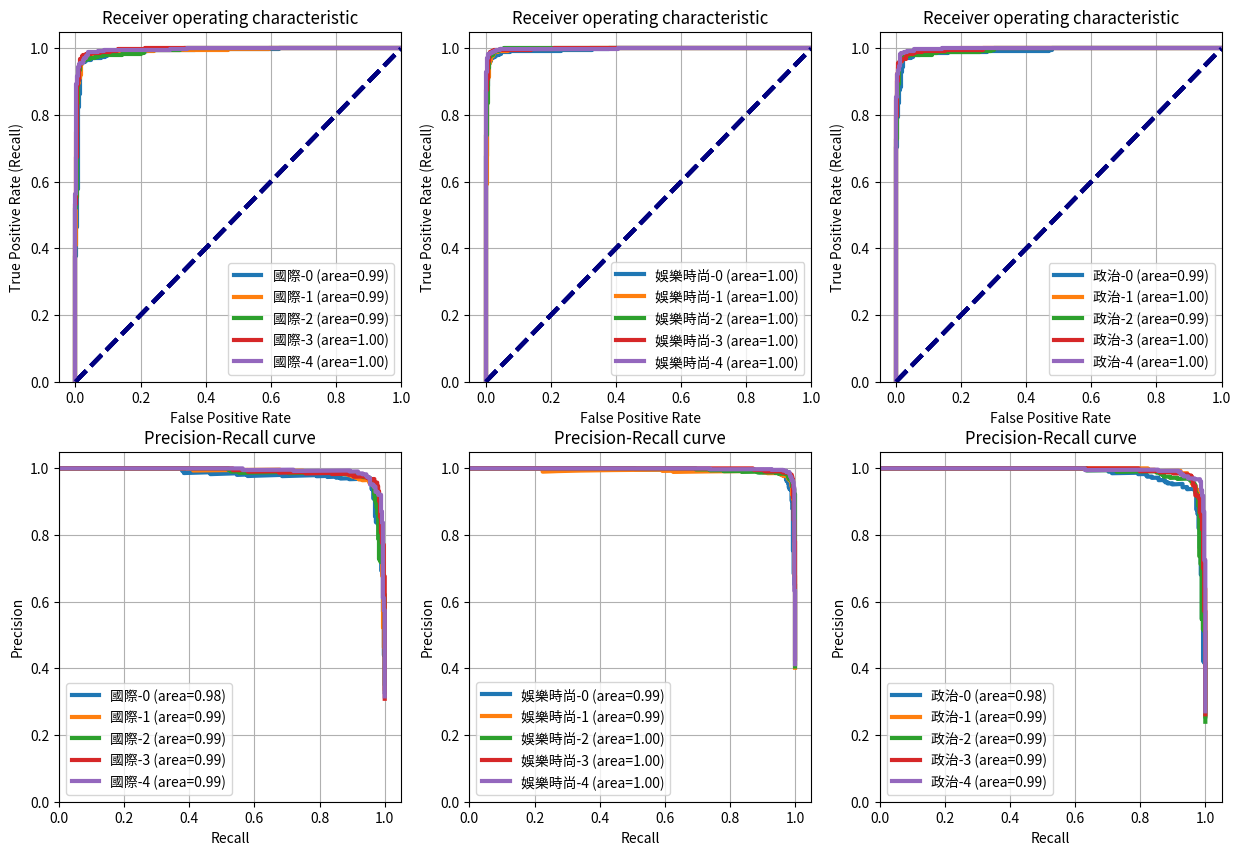

In [42]:
## 將三個新聞類別的 ROC curve 分別畫出來，並在同一張圖上比較不同 fold 的結果
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
kf = KFold(n_splits=5)
classes = scores['estimator'][0].classes_

for k, (train, test) in enumerate(kf.split(vec_train, y_train)):
    clf.fit(vec_train[train,:], y_train.iloc[train])
    y_pred = clf.predict(vec_train[test,:])    
    y_test = y_train.iloc[test]
    y_pred_proba = clf.predict_proba(vec_train[test,:])
    y_onehot_test = label_binarizer.transform(y_test)        
    

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0,i].plot(
            fpr,
            tpr,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
        )
        ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
        ax[0,i].set(
            xlim=[-0.05, 1.0],
            ylim=[0.0, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate (Recall)",
            title="Receiver operating characteristic",
        )
        ax[0,i].legend(loc="best")
        ax[0,i].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1,i].plot(
            recall,
            precision,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
        )
        ax[1,i].set(
            xlim=[0.0, 1.05],
            ylim=[0.0, 1.05],
            xlabel="Recall",
            ylabel="Precision",
            title="Precision-Recall curve",
        )
        ax[1,i].legend(loc="best")
        ax[1,i].grid(True)

plt.show()

## 4. 比較不同模型效果

In [43]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)


    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    kf = KFold(n_splits=5)
    
    for k, (train, test) in enumerate(kf.split(vec_X, y)):
        clf.fit(vec_X[train,:], y.iloc[train])
        y_pred = clf.predict(vec_X[test,:])    
        y_test = y.iloc[test]
        y_pred_proba = clf.predict_proba(vec_X[test,:])
        y_onehot_test = label_binarizer.transform(y_test)        
        
    
        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
            ax[0,i].plot(
                fpr,
                tpr,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
            )
            ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
            ax[0,i].set(
                xlim=[-0.05, 1.0],
                ylim=[0.0, 1.05],
                xlabel="False Positive Rate",
                ylabel="True Positive Rate (Recall)",
                title="Receiver operating characteristic",
            )
            ax[0,i].legend(loc="best")
            ax[0,i].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = precision_recall_curve(
                y_onehot_test[:, i], y_pred_proba[:, i]
            )
            ax[1,i].plot(
                recall,
                precision,
                lw=3,
                label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
            )
            ax[1,i].set(
                xlim=[0.0, 1.05],
                ylim=[0.0, 1.05],
                xlabel="Recall",
                ylabel="Precision",
                title="Precision-Recall curve",
            )
            ax[1,i].legend(loc="best")
            ax[1,i].grid(True)

    plt.show()

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

              precision    recall  f1-score   support

          國際       0.96      0.96      0.96      1841
        娛樂時尚       0.97      0.98      0.98      2306
          政治       0.97      0.95      0.96      1439

    accuracy                           0.97      5586
   macro avg       0.97      0.96      0.96      5586
weighted avg       0.97      0.97      0.97      5586



c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

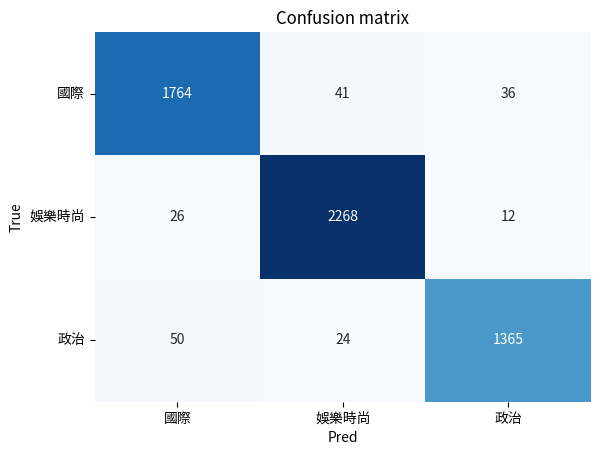

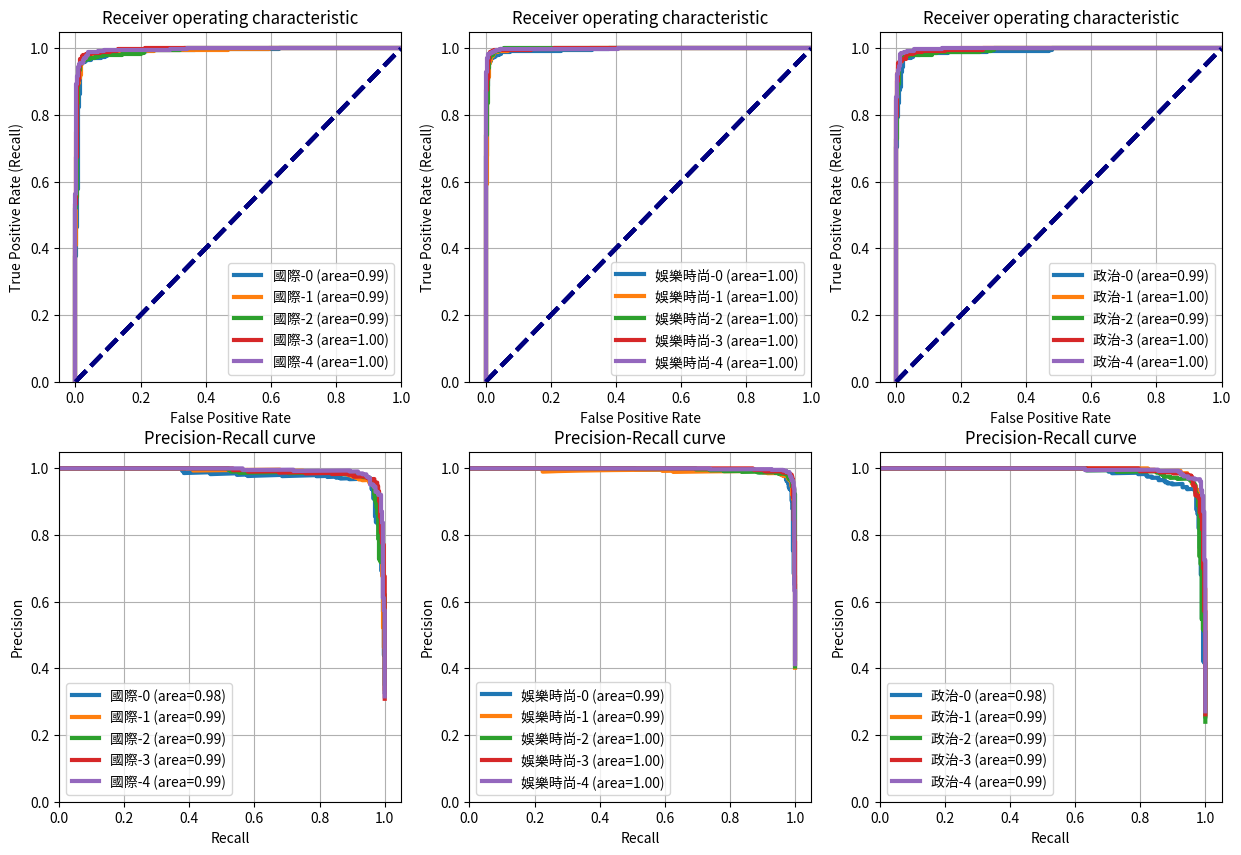

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

              precision    recall  f1-score   support

          國際       0.96      0.96      0.96      1841
        娛樂時尚       0.97      0.98      0.98      2306
          政治       0.97      0.95      0.96      1439

    accuracy                           0.97      5586
   macro avg       0.97      0.96      0.96      5586
weighted avg       0.97      0.97      0.97      5586



c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

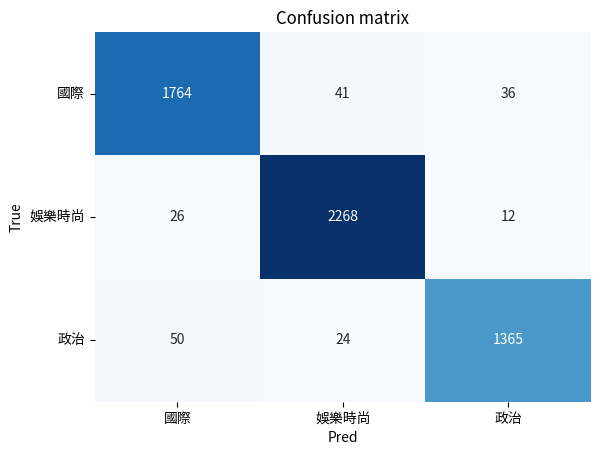

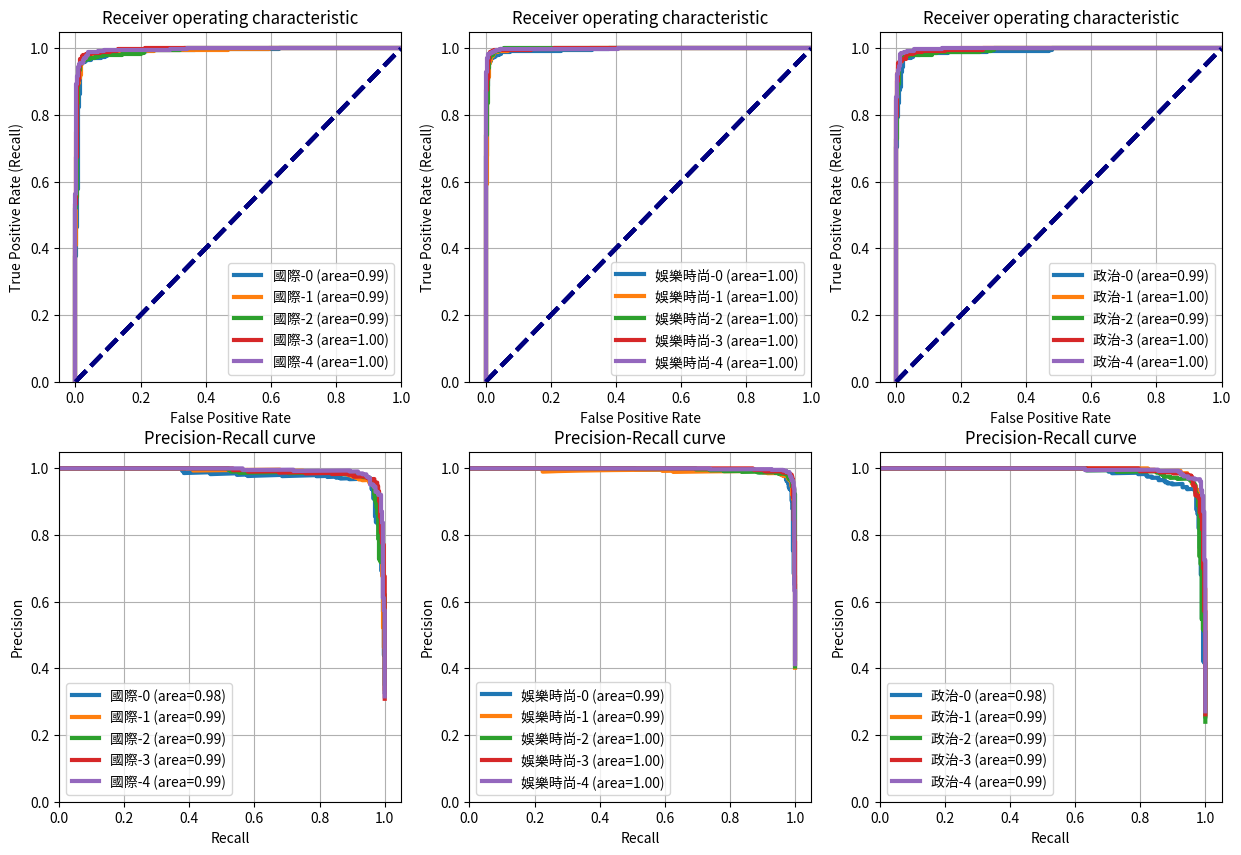

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


now training: clf_dtree
              precision    recall  f1-score   support

          國際       0.93      0.94      0.93      1841
        娛樂時尚       0.95      0.95      0.95      2306
          政治       0.94      0.92      0.93      1439

    accuracy                           0.94      5586
   macro avg       0.94      0.94      0.94      5586
weighted avg       0.94      0.94      0.94      5586



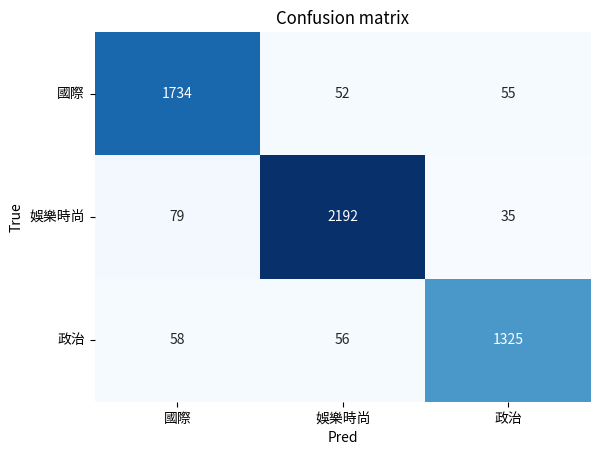

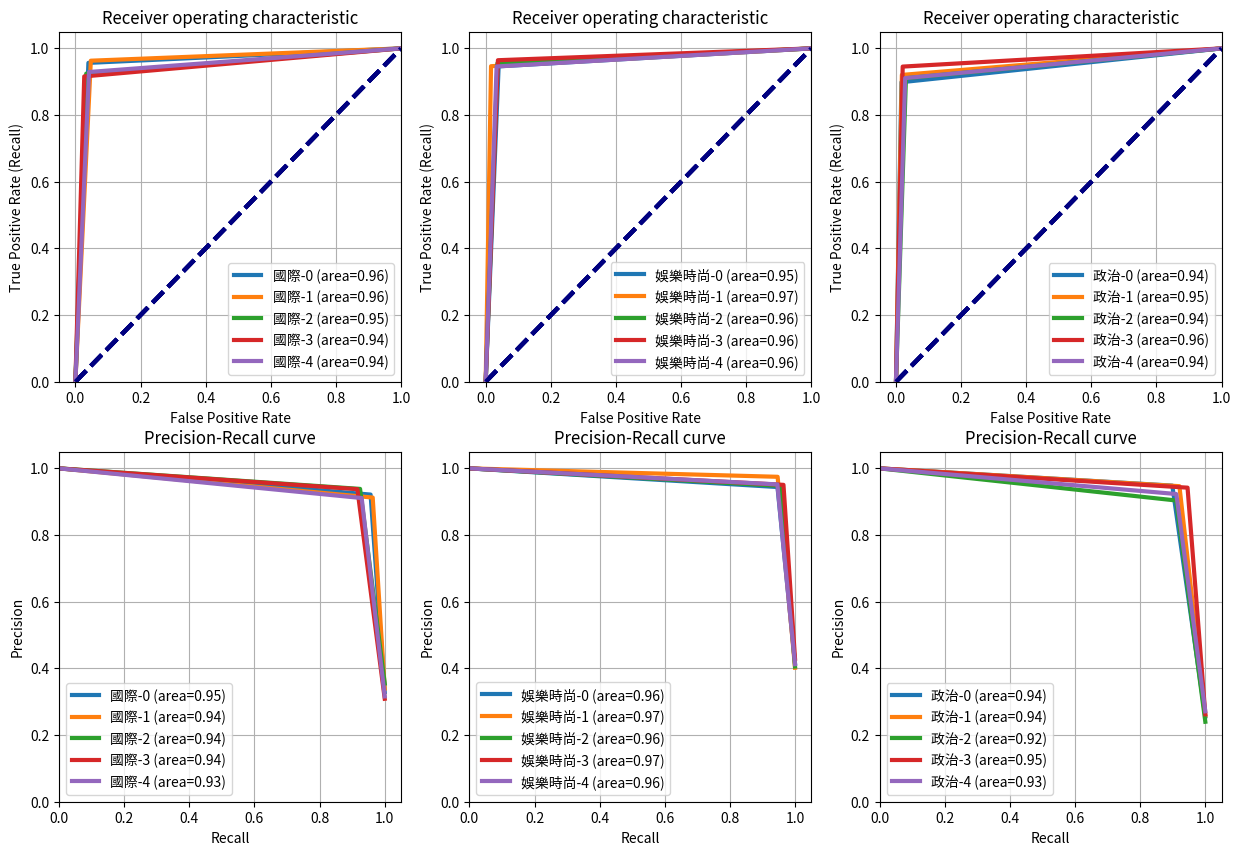

In [45]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
# model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = CountVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

In [46]:
result_set['clf_logistic']

{'國際': {'precision': 0.9586956521739131,
  'recall': 0.9581749049429658,
  'f1-score': 0.958435207823961,
  'support': 1841},
 '娛樂時尚': {'precision': 0.9721388769824261,
  'recall': 0.9835212489158717,
  'f1-score': 0.9777969389954732,
  'support': 2306},
 '政治': {'precision': 0.9660297239915074,
  'recall': 0.9485753995830438,
  'f1-score': 0.9572230014025246,
  'support': 1439},
 'accuracy': 0.9661654135338346,
 'macro avg': {'precision': 0.9656214177159489,
  'recall': 0.9634238511472938,
  'f1-score': 0.9644850494073195,
  'support': 5586},
 'weighted avg': {'precision': 0.966134571929364,
  'recall': 0.9661654135338346,
  'f1-score': 0.9661157998470652,
  'support': 5586}}

In [47]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['macro avg'][best_model_metric] > max:
        max = v['macro avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'accuracy': 0.9661654135338346,
 'macro avg': {'f1-score': 0.9644850494073195,
               'precision': 0.9656214177159489,
               'recall': 0.9634238511472938,
               'support': 5586},
 'weighted avg': {'f1-score': 0.9661157998470652,
                  'precision': 0.966134571929364,
                  'recall': 0.9661654135338346,
                  'support': 5586},
 '國際': {'f1-score': 0.958435207823961,
        'precision': 0.9586956521739131,
        'recall': 0.9581749049429658,
        'support': 1841},
 '娛樂時尚': {'f1-score': 0.9777969389954732,
          'precision': 0.9721388769824261,
          'recall': 0.9835212489158717,
          'support': 2306},
 '政治': {'f1-score': 0.9572230014025246,
        'precision': 0.9660297239915074,
        'recall': 0.9485753995830438,
        'support': 1439}}


In [48]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.96      0.96      0.96       837
        娛樂時尚       0.97      0.97      0.97       958
          政治       0.96      0.95      0.96       600

    accuracy                           0.96      2395
   macro avg       0.96      0.96      0.96      2395
weighted avg       0.96      0.96      0.96      2395



In [49]:
model_set['clf_logistic'].predict(vectorizer.transform(["市場 將 迎來 許多 大企業 的 財報 美國 股市 主要指數 今天 早盤 小幅震盪"]))

array(['國際'], dtype=object)

* logistic 的模型表現比決策樹的略好一點。
* 另外也可以嘗試用 tfidf 作為 `vectorizer`，比較看看相較直接的詞頻表，是否效果更好。
* 當 label 的類別不平衡的時候，會需要用其他手法或更複雜的模型，來解決資料類別不平衡的問題

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [50]:
model_set[best_model_name]

LogisticRegression()

In [51]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

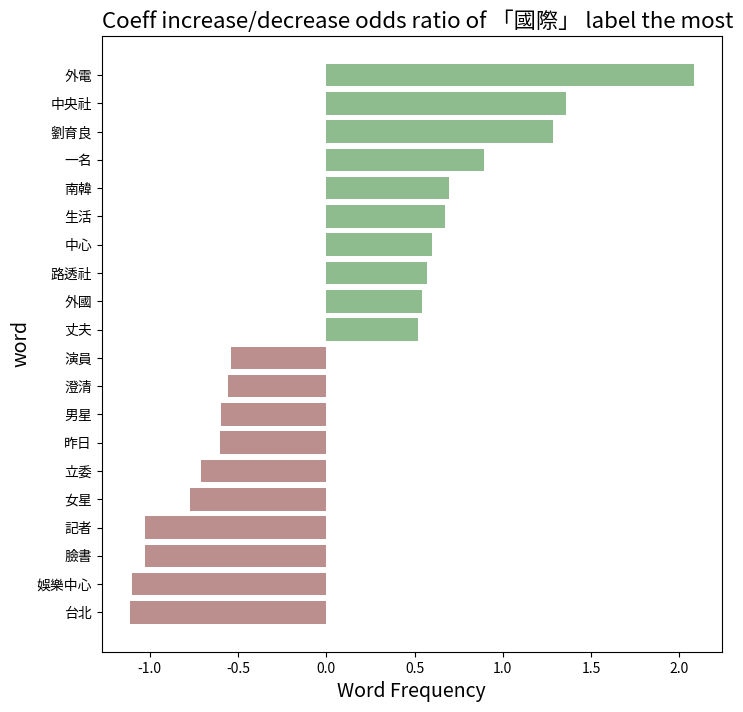

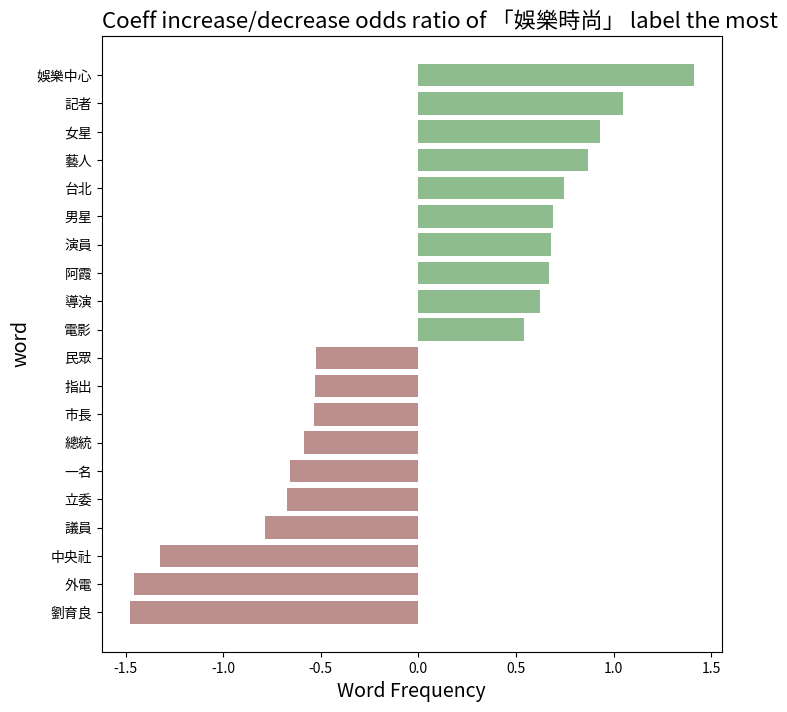

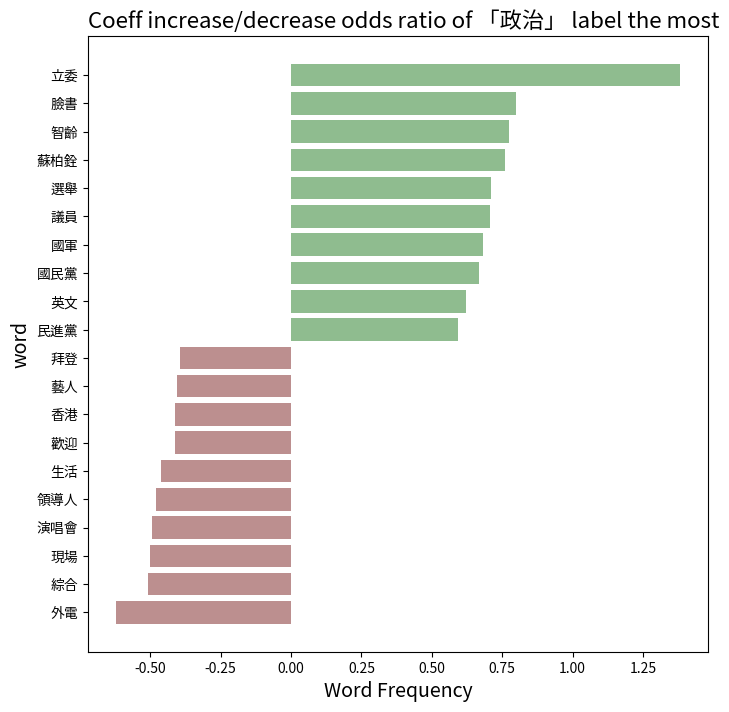

In [52]:
plot_coef(logistic_reg_model=model_set[best_model_name], feature_names=vectorizer.get_feature_names_out(), top_n=10)

「娛樂時尚」中高係數的字多半與演員、藝人有關；「國際」則是外電、中央社相關的字，「政治」中影響最大的字是立委。

## 6. 預測新聞類別
我們另外用中時新聞網針對娛樂、政治與國際三個新聞版去做預測 <br>
資料時間: 2022年 4月

In [53]:
ct = pd.read_csv("./raw_data/chinatimes_data.csv")
ct.dropna(inplace=True)
ct

,system_id,artUrl,artCatagory,artTitle,artDate,artContent,dataSource
0,1,https://www.chinatimes.com/newspapers/20230401...,政治,外媒爆 蔡總統雷根圖書館演說恐生變,2023-04-01 04:10:00,蔡英文總統出訪中美洲友邦途中過境美國，美東時間3月30日晚間，在紐約受邀出席美國「哈德遜研究...,chinatimes
1,2,https://www.chinatimes.com/newspapers/20230401...,政治,挺侯聯盟第1波 10藍委籲黨中央速徵召,2023-04-01 04:10:00,國民黨2024總統大選將以徵召方式決定人選，黨中央雖已積極展開徵詢，但目前黨內最強母雞就是新...,chinatimes
2,3,https://www.chinatimes.com/newspapers/20230401...,政治,徐弘庭斥黨員投票水很深 宣布退選,2023-04-01 04:10:00,國民黨立委初選內鬥不斷，台北市第8選區（中正、文山）初選方式採37制，原本有意投入初選的北市...,chinatimes
3,4,https://www.chinatimes.com/newspapers/20230401...,政治,曾銘宗：侯目前民調是地板 表態後會上升,2023-04-01 04:10:00,曾多次準確預測台灣選舉結果的日本學者小笠原欣幸，日前評價國民黨潛在候選人、新北市長侯友宜民調...,chinatimes
4,5,https://www.chinatimes.com/newspapers/20230401...,政治,郝龍斌支持徵召 籲朱立倫公開說不選總統,2023-04-01 04:10:00,國民黨中央日前拍板以徵召方式提名2024總統參選人，但提名辦法、時程遲未公布，黨內憂心持續拖...,chinatimes
...,...,...,...,...,...,...,...
6680,6681,https://www.chinatimes.com/realtimenews/202304...,國際,因應台海危機 日本糧食自給率太低 準備立法強制農民變更作物,2023-04-29 19:56:00,由於日本高度依賴糧食進口，為因應烏俄戰爭和潛在的台海危機，以及氣候變遷影響，導致日本食物短缺...,chinatimes
6681,6682,https://www.chinatimes.com/realtimenews/202304...,國際,拜登5月訪巴紐 預計會晤18位太平洋島國領袖,2023-04-29 22:18:00,美中兩國競逐太平洋地區影響力之際，巴布亞紐幾內亞外長特卡琴科今天表示，美國總統拜登於5月造訪...,chinatimes
6682,6683,https://www.chinatimes.com/realtimenews/202304...,國際,「抗老延壽」重要突破！美名校研究讓細胞壽命大增8成,2023-04-29 20:47:00,「抗老化」已成顯學，學界也有愈來愈多人認為「老化」可以治療。美國研究團隊透過酵母菌實驗發現細...,chinatimes
6683,6684,https://www.chinatimes.com/realtimenews/202304...,國際,美韓共同防禦概念升級 尹錫悅：《華盛頓宣言》涵蓋核保護傘,2023-04-29 22:07:00,韓國總統尹錫悅28日到美國哈佛大學甘迺迪政府學院（Kennedy School）發表演說，隨...,chinatimes


In [54]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,外媒爆 蔡總統雷根圖書館演說恐生變蔡英文總統出訪中美洲友邦途中過境美國，美東時間3月30日晚...,https://www.chinatimes.com/newspapers/20230401...,政治,外媒爆 總統 雷根 圖書館 演說 生變 英文 總統 出訪 中美洲 友邦 途中 過境 美國 美...
1,挺侯聯盟第1波 10藍委籲黨中央速徵召國民黨2024總統大選將以徵召方式決定人選，黨中央雖已...,https://www.chinatimes.com/newspapers/20230401...,政治,挺侯 聯盟 10 藍委籲 黨中央 徵召 國民黨 2024 總統大選 將以 徵召 方式 決定 ...
2,徐弘庭斥黨員投票水很深 宣布退選國民黨立委初選內鬥不斷，台北市第8選區（中正、文山）初選方式...,https://www.chinatimes.com/newspapers/20230401...,政治,徐弘庭斥 黨員 投票 宣布 退選 國民黨 立委 初選 不斷 台北市 選區 中正 文山 初選 ...
3,曾銘宗：侯目前民調是地板 表態後會上升曾多次準確預測台灣選舉結果的日本學者小笠原欣幸，日前評...,https://www.chinatimes.com/newspapers/20230401...,政治,曾銘宗 目前 民調 地板 表態 上升 曾多次 準確 預測 台灣 選舉 日本 學者 小笠 欣幸...
4,郝龍斌支持徵召 籲朱立倫公開說不選總統國民黨中央日前拍板以徵召方式提名2024總統參選人，但...,https://www.chinatimes.com/newspapers/20230401...,政治,郝龍斌 支持 徵召 籲朱 立倫公 開說 不選 總統 國民黨中央 日前 拍板 徵召 方式 提名...


In [55]:
ct['artCatagory'].value_counts()

artCatagory
政治    3124
娛樂    2295
國際    1256
Name: count, dtype: int64

In [58]:
# mapper = {"國際":"國際", "政治":"政治", "娛樂時尚":"娛樂"}
# ct['artCatagory'] = ct['artCatagory'].map(mapper)

# X = ct['words']
# y = ct['artCatagory']
# y_pred = model_set[best_model_name].predict(vectorizer.transform(X))
# print(classification_report(y, y_pred))

In [ ]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,外媒爆 總統 雷根 圖書館 演說 生變 英文 總統 出訪 中美洲 友邦 途中 過境 美國 美...,政治,政治
1,挺侯 聯盟 10 藍委籲 黨中央 徵召 國民黨 2024 總統大選 將以 徵召 方式 決定 ...,政治,政治
2,徐弘庭斥 黨員 投票 宣布 退選 國民黨 立委 初選 不斷 台北市 選區 中正 文山 初選 ...,政治,政治
3,曾銘宗 目前 民調 地板 表態 上升 曾多次 準確 預測 台灣 選舉 日本 學者 小笠 欣幸...,政治,政治
4,郝龍斌 支持 徵召 籲朱 立倫公 開說 不選 總統 國民黨中央 日前 拍板 徵召 方式 提名...,政治,政治
...,...,...,...
6680,因應 台海 危機 日本 糧食 自給率 太低 準備 立法 強制 農民 變更 作物 日本 高度 ...,國際,國際
6681,拜登 訪巴紐 預計 會晤 18 太平洋 島國 領袖 美中 兩國 競逐 太平洋地區 影響力 之...,國際,國際
6682,抗老 延壽 重要 突破 名校 研究 細胞 壽命 大增 抗老化 已成 顯學 學界 愈來愈多 認...,國際,國際
6683,美韓 共同 防禦 概念 升級 尹錫悅 華盛頓 宣言 涵蓋 保護傘 韓國 總統 尹錫悅 28 ...,國際,國際


In [ ]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
16,馬英九 祖父 團練 後人 傳頌 善舉 總統 馬英九 返鄉 祭祖 祖父 立安 過往 行善 事蹟...,政治,國際
28,湖南衛視 錄影 高歌 月亮代表 總統 馬英九 率團 訪問 大陸 參觀 湖南衛視 聲生 不息 ...,政治,國際
30,美眾院 中國 委員會 主席 將在 加州 會晤 英文 英文 總統 正在 中美洲 友邦 訪問 美...,政治,國際
33,美國 時間 英文 過境 加州 會見 麥卡錫 英文 總統 昨日 抵達 貝里斯 總統府 美國國會...,政治,國際
34,化解 對立 兩岸 理性 下來 溝通 總統 馬英九 率大九 學堂 年輕 學子 訪問 大陸 武漢...,政治,國際
...,...,...,...
6619,Meta 財報 亮眼 美股 收高 道瓊 上漲 524 那指 飆升 2.43 臉書 Faceb...,國際,政治
6636,梅根 宣布 復出 簽約 知名 經紀 公司 有望 轉當 導演 延續 演藝 正當 英國 緊鑼密鼓...,國際,娛樂時尚
6650,股價 持續 崩跌 美國 第一 共和 銀行 陷入困境 美國 地區性 銀行 第一 共和 銀行 F...,國際,政治
6659,募款 夠了 台誤 老鼠藥 澳洲 大學生 回家 澳洲 昆士蘭 大學 The Universit...,國際,娛樂時尚


In [ ]:
false_pred.loc[false_pred['artCatagory']=='政治', :]

,words,artCatagory,pred
16,馬英九 祖父 團練 後人 傳頌 善舉 總統 馬英九 返鄉 祭祖 祖父 立安 過往 行善 事蹟...,政治,國際
28,湖南衛視 錄影 高歌 月亮代表 總統 馬英九 率團 訪問 大陸 參觀 湖南衛視 聲生 不息 ...,政治,國際
30,美眾院 中國 委員會 主席 將在 加州 會晤 英文 英文 總統 正在 中美洲 友邦 訪問 美...,政治,國際
33,美國 時間 英文 過境 加州 會見 麥卡錫 英文 總統 昨日 抵達 貝里斯 總統府 美國國會...,政治,國際
34,化解 對立 兩岸 理性 下來 溝通 總統 馬英九 率大九 學堂 年輕 學子 訪問 大陸 武漢...,政治,國際
...,...,...,...
3091,董痛 批台 觀光 政府 跳腳 旅遊 達人 殘酷 事實 小吃 星宇 航空 董事長 張國煒 近日...,政治,國際
3096,擔任 文化 局長 蔡詩萍 點名 心聲 台北 市長 萬安 上任 邀請 資深 媒體 蔡詩萍 擔任...,政治,娛樂時尚
3116,李貴敏批 經濟 成長 破功 官員 自欺欺人 主計 總處 公布 經濟 成長率 概估 為負 3....,政治,國際
3129,日起 指揮中心 解編 最新 網路 民調 成民眾 一面倒 新冠 肺炎 將於 降級 第四類 法定...,政治,國際


In [ ]:
pprint(false_pred['words'][74])

('蔡麥會 平台 獨蔡 英文 預計 加州 時間 雷根 圖書館 美國 議院 議長 麥卡錫 大陸 福建 宣布 反制 台灣 海峽 中北部 聯合 巡航 巡查 行動 '
 '啟動 這次 會面 地點 雷根 圖書館 民間 屬性 感覺 象徵意義 十足 麥卡錫 還在 事前 廣發 採訪 通知 還力 邀眾 議院 各方 議員 一起 參加 '
 '英文 座談 反正 場面 越大越 麥卡錫 不虧 打個 台灣牌 出風頭 百利 無一害 目標 超越 裴洛西 去年 訪台灣 美國 台獨 英文 麥卡錫 加州 會面 '
 '把眾 議院 議長 台灣 領導人 見面 變成 一種 慣例 2018 美國 台灣 旅行 之後 美國 一直 推動 台灣 各級 官員 互訪 部長級 官員 互訪 '
 '以前 罕見 現在 已經 見怪不怪 絡繹於途 台灣 上推 到眾 議院 議長 台灣 領導人 美國 過境 變成 訪問 這對 美國 來說 必然 操作 2018 '
 '法案 已經 陽謀 已經 授權 當眾 議院 議長 台灣 領導人 會面 變成 第三次 第四次 之後 變成 常態 推進 國務卿 總統 美國國會 作用 更是 '
 '妙不可言 台灣用 納稅人 僑委會 補貼 NGO 美國 收買 國會議員 各類 政客 媒體 持續性 推動 台獨 法案 台獨 反華 目標 一致 美國 政治 '
 '大氣候 契合 政客 樂於 配合 美國國會 成為 反華 台獨 火車頭 違反 外交關係 違反 一中 立場 中方 抗議 美國政府 只會 聳聳肩 這是 國會 '
 '管不了 國會 一趟 過境 一場 會面 幹什麼 美國 台灣 當局 國際 曝光 表演 效果 一再 世界 看到 台灣 全世界 覺得 台灣 國家 感覺 各國 '
 '成形 更會 政客 支持 台獨 妖魔化 大陸 捍衛 國土 正當 行為 一邊 和平 一邊 台獨 這是 台獨 上策 英文 過境 會面 平台 問題 台灣 看得 '
 '清楚 台灣會 和平 越遠 馬英九 一趟 大陸行 點出 兩岸 同屬 一中 本質 台灣 本質 中國 領土 脫離 本質 玩台 這是 美利堅 玩台灣')


模型對另一個新聞網的預測結果比較普通。不過，其中很大一部分預測錯的類別，是把「股市」預測成「兩岸」。當我們把這個類別的錯誤挑出來看，可以發現這些預測錯的股市新聞，多半也算與國際地緣政治相關的財經新聞。

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。
* 在這裡可以看到個不同模型的 F1-score 都不會差到太多，代表就算只用 1000 維的 DTM 來代表一篇文章，其實也是有一定程度地的預測能力。

## 6. 教學目標
1. 能夠利用 DTM 將文章表示成一串數字，以利後續的分析或預測任務使用
2. 能夠使用機器學習流程，訓練一個文集分類模型
    * 額外提問：只要能夠把文字資料轉換成 `input` 與 `label` 的形式，就能夠來訓練預測模型。例如本週就是將新聞轉成數字 input，label 為新聞類別。文字分析中有哪些可能的應用場景？
        * 用企業的財報預測企業股價/ROA?
        * 用總統候選人的選前演講稿預測得票率？
3. 能夠解釋在可解釋模型中，詞頻/tfidf 作為 input feature 的意義

## 附錄

In [ ]:
# 定義模型訓練組合
## 不做 cross validation, 用 test data 來評估模型的版本
## pipeline: 資料處理 vectorizer + 分類器
def train(vectorizer, clf, X_train, y_train, X_test, y_test):

    ## train classifier
    vec_train = vectorizer.fit_transform(X_train).toarray()
    vec_test = vectorizer.transform(X_test).toarray()
    clf.fit(vec_train, y_train)
    

    ## test classifier
    y_pred = clf.predict(vec_test)
    y_pred_proba = clf.predict_proba(vec_test)

    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    ## Accuracy, Precision, Recall, F1-score
    print(classification_report(y_test, y_pred))

    classes = clf.classes_
    ## Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0].plot(
            fpr,
            tpr,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr)),
        )
    ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
    ax[0].set(
        xlim=[-0.05, 1.0],
        ylim=[0.0, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate (Recall)",
        title="Receiver operating characteristic",
    )
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1].plot(
            recall,
            precision,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
        )
    ax[1].set(
        xlim=[0.0, 1.05],
        ylim=[0.0, 1.05],
        xlabel="Recall",
        ylabel="Precision",
        title="Precision-Recall curve",
    )
    ax[1].legend(loc="best")
    ax[1].grid(True)

    plt.show()

    # return the model object
    return classification_report(y_test, y_pred, output_dict=True)


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

          國際       0.96      0.96      0.96       837
        娛樂時尚       0.97      0.97      0.97       958
          政治       0.96      0.95      0.96       600

    accuracy                           0.96      2395
   macro avg       0.96      0.96      0.96      2395
weighted avg       0.96      0.96      0.96      2395



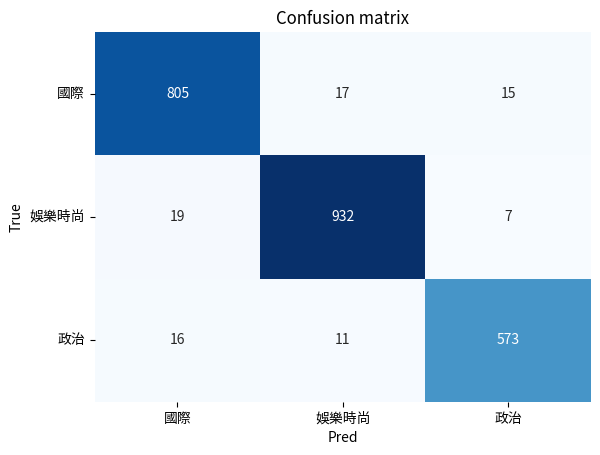

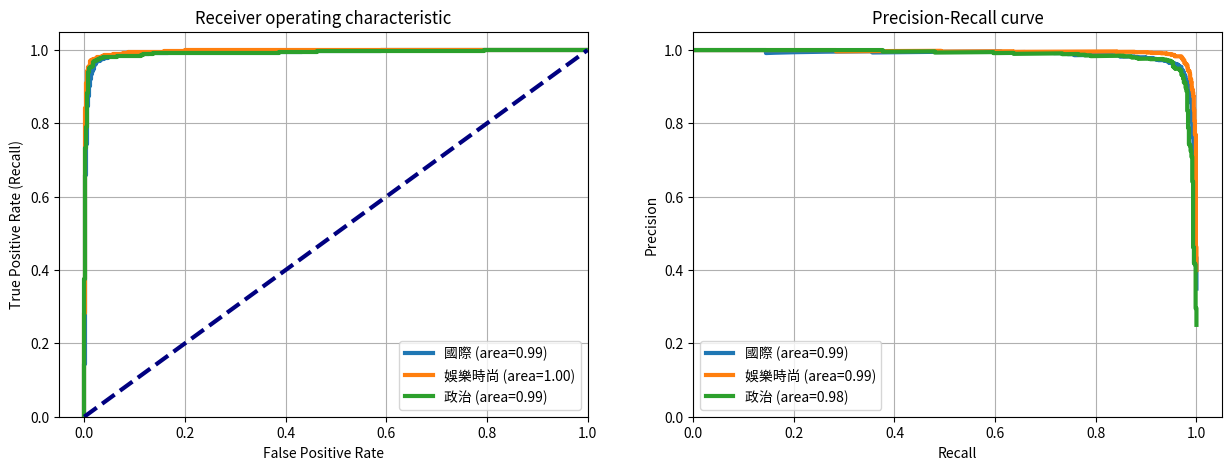

{'國際': {'precision': 0.9583333333333334,
  'recall': 0.961768219832736,
  'f1-score': 0.9600477042337507,
  'support': 837},
 '娛樂時尚': {'precision': 0.9708333333333333,
  'recall': 0.9728601252609603,
  'f1-score': 0.9718456725755995,
  'support': 958},
 '政治': {'precision': 0.9630252100840336,
  'recall': 0.955,
  'f1-score': 0.9589958158995815,
  'support': 600},
 'accuracy': 0.964509394572025,
 'macro avg': {'precision': 0.9640639589169001,
  'recall': 0.9632094483645655,
  'f1-score': 0.9636297309029773,
  'support': 2395},
 'weighted avg': {'precision': 0.9645087513084566,
  'recall': 0.964509394572025,
  'f1-score': 0.9645033704846858,
  'support': 2395}}

In [ ]:
data = udn
X = data["words"]
y = data["artCatagory"]
# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
train(vectorizer, clf, X_train, y_train, X_test, y_test)

    畫出決策樹的 code

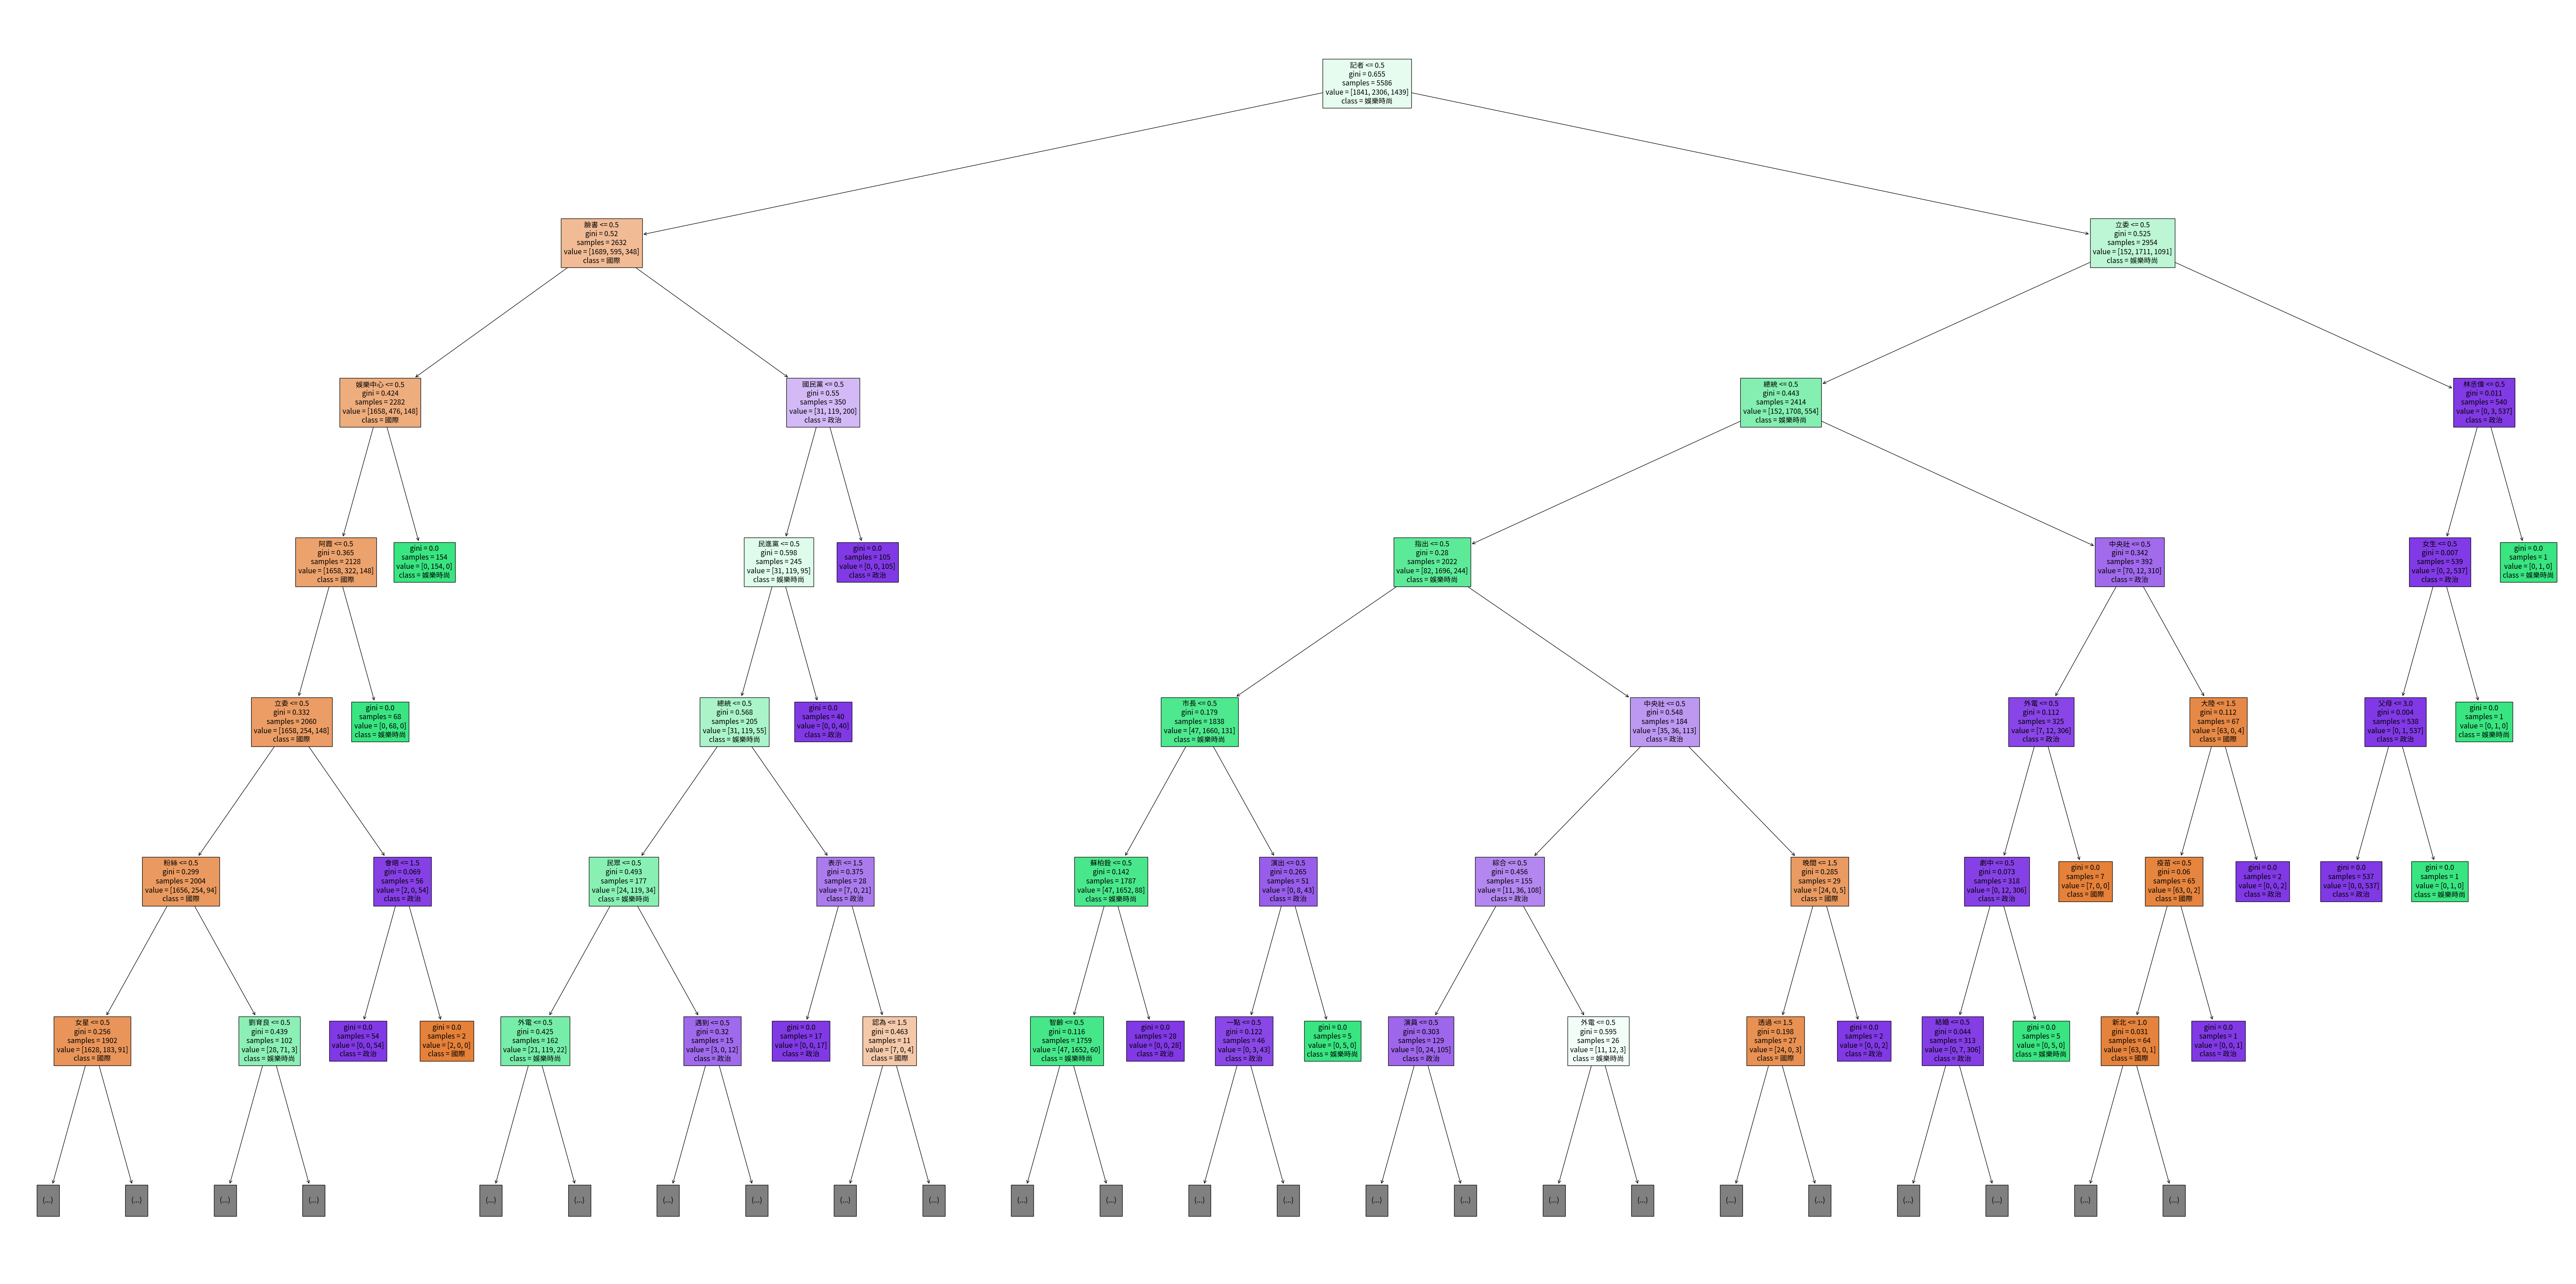

In [ ]:
fig = plt.figure()
fig.set_size_inches(90, 45)
plot_tree(
    model_set["clf_dtree"], 
    max_depth=6, # 最大深度
    feature_names=vectorizer.get_feature_names_out(), 
    class_names=model_set["clf_dtree"].classes_,
    filled=True
)
fig.savefig("decistion_tree.png")

## 主題模型

**主題模型** ，如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型。<br>
<br>
分為7個部分：
1. 介紹使用到的套件 
2. 將資料進行前處理 
3. lexicon-based 的主題模型
4. LDA 主題模型 
5. 視覺化主題模型 
6. 主題模型的應用

## 1. 套件說明

+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [ ]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["Noto Sans CJK JP"]
# plt.plot((1, 2, 3), (4, 3, -1))
# plt.title("聲量圖")

## 2. 資料前處理

In [ ]:
udn = pd.read_csv("raw_data/apple_data.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,女團HUR熱舞秀辣腿 師弟VERA尬場香味撲鼻,2023-03-01 16:31:00,娛樂時尚,https://tw.nextapple.com/entertainment/2023030...,【記者林丞偉／台北報導】新世代唱跳女團「HUR」由利善榛、裴頡、C.Holly、連穎、巴倫⽉...,appleDaily
1,2,這個貼身教練讓「運動控」超放心 G-SHOCK新智慧錶有感升級還很輕,2023-03-01 22:57:00,娛樂時尚,https://tw.nextapple.com/entertainment/2023030...,【記者邱瓈瑩／台北報導】日本鐘錶品牌卡西歐（CASIO）繼日前宣布韓國女團ITZY成為旗下耐...,appleDaily
2,3,最想被翻拍的BL小說《奇蹟》開鏡 謝承均與亮哲親密關係不藏了,2023-03-01 19:17:00,娛樂時尚,https://tw.nextapple.com/entertainment/2023030...,【記者趙大智／台北報導】八大BL劇集《奇蹟》今日開鏡，在《俗女養成記》2季傳神演出同志弟弟的...,appleDaily


In [ ]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,記者林丞偉台北報導新世代唱跳女團由利善榛裴頡連穎巴倫席淇組成適逢出道年前夕在台北三創舉辦首場...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 16:31:00
1,記者邱瓈瑩台北報導日本鐘錶品牌卡西歐繼日前宣布韓國女團成為旗下耐衝擊腕錶品牌大使藉此宣告加緊...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 22:57:00
2,記者趙大智台北報導八大劇集奇蹟今日開鏡在俗女養成記季傳神演出同志弟弟的宋偉恩這次擺脫過往角色...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 19:17:00


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from c:\Users\user\Desktop\week12\dict\dict.txt ...
2023-05-08 02:29:09,309 : DEBUG : Building prefix dict from c:\Users\user\Desktop\week12\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u0716be951a03b66bbad8fc65fd3da84b.cache
2023-05-08 02:29:09,312 : DEBUG : Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u0716be951a03b66bbad8fc65fd3da84b.cache
Loading model cost 0.777 seconds.
2023-05-08 02:29:10,088 : DEBUG : Loading model cost 0.777 seconds.
Prefix dict has been built successfully.
2023-05-08 02:29:10,090 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,記者林丞偉台北報導新世代唱跳女團由利善榛裴頡連穎巴倫席淇組成適逢出道年前夕在台北三創舉辦首場...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 16:31:00,"[記者, 林丞偉, 台北, 報導, 新世代, 唱跳, 女團, 由利善, 裴頡連穎, 巴倫席,..."
1,記者邱瓈瑩台北報導日本鐘錶品牌卡西歐繼日前宣布韓國女團成為旗下耐衝擊腕錶品牌大使藉此宣告加緊...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 22:57:00,"[記者, 台北, 報導, 日本, 鐘錶, 品牌, 卡西歐, 日前, 宣布, 韓國, 女團, ..."
2,記者趙大智台北報導八大劇集奇蹟今日開鏡在俗女養成記季傳神演出同志弟弟的宋偉恩這次擺脫過往角色...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 19:17:00,"[記者, 大智, 台北, 報導, 八大, 劇集, 奇蹟, 今日, 開鏡, 俗女, 養成, 記..."
3,記者張家玲台北報導月的第一天迎來了明媚的好天氣紐約時尚品牌也放送了好消息宣布女神舒淇成為品牌...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 16:20:00,"[記者, 張家, 台北, 報導, 第一天, 迎來, 明媚, 天氣, 紐約, 時尚, 品牌, ..."
4,記者葉文正台北報導民視醫學大聯盟帶大家探討哪些行為有助於平衡免疫力改善整體健康節目日前邀請到...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 09:05:00,"[記者, 文正, 台北, 報導, 民視, 醫學, 大聯盟, 探討, 行為, 有助於, 平衡,..."


## 3. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文黨集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

In [ ]:
vocab = {'喜歡': 0, '小美': 1, '自然語言處理': 2, '文字分析': 3}

sample_docs = ["小美 喜歡 自然語言處理","小美 喜歡 文字分析"]
vectorizer = CountVectorizer(vocabulary=vocab)
dtm = vectorizer.fit_transform(sample_docs)
features = vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(dtm.toarray(), columns=features)
dtm_df

,喜歡,小美,自然語言處理,文字分析
0,1,1,1,0
1,1,1,0,1


In [ ]:
# for gensim
sample_docs2 =  [doc.split() for doc in sample_docs]
sample_docs2

[['小美', '喜歡', '自然語言處理'], ['小美', '喜歡', '文字分析']]

In [ ]:
dct = Dictionary(sample_docs2)
print(dct)

2023-05-08 02:31:54,906 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-05-08 02:31:54,907 : INFO : built Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']> from 2 documents (total 6 corpus positions)
2023-05-08 02:31:54,908 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']> from 2 documents (total 6 corpus positions)", 'datetime': '2023-05-08T02:31:54.908460', 'gensim': '4.3.1', 'python': '3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


Dictionary<4 unique tokens: ['喜歡', '小美', '自然語言處理', '文字分析']>


In [ ]:
dct.token2id

{'喜歡': 0, '小美': 1, '自然語言處理': 2, '文字分析': 3}

In [ ]:
print(sample_docs2[0])
dct.doc2bow(sample_docs2[0])

['小美', '喜歡', '自然語言處理']


[(0, 1), (1, 1), (2, 1)]

In [ ]:
sample_corpus = [dct.doc2bow(doc) for doc in sample_docs2]
sample_corpus

[[(0, 1), (1, 1), (2, 1)], [(0, 1), (1, 1), (3, 1)]]

In [ ]:
# corpus 轉換成 dtm
dtm_c = corpus2dense(sample_corpus, num_terms=len(dct.token2id), num_docs=len(sample_corpus))
dtm_c

array([[1., 1.],
       [1., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
dtm_c.T

array([[1., 1., 1., 0.],
       [1., 1., 0., 1.]], dtype=float32)

In [ ]:
dtm_df

,喜歡,小美,自然語言處理,文字分析
0,1,1,1,0
1,1,1,0,1


**3.1 正式處理新聞版**

In [ ]:
docs = udn['words'].to_list()
docs[0]

['記者',
 '林丞偉',
 '台北',
 '報導',
 '新世代',
 '唱跳',
 '女團',
 '由利善',
 '裴頡連穎',
 '巴倫席',
 '組成',
 '適逢',
 '出道',
 '前夕',
 '台北',
 '三創',
 '舉辦',
 '首場',
 '演唱會',
 '一口氣',
 '選秀',
 '出道',
 '逾首歌',
 '化身為',
 '黑白',
 '舞力',
 '天使',
 '大秀',
 '辣腿',
 '美不勝收',
 '周湯豪',
 '閻奕格',
 '木木',
 '派崔克',
 '到場',
 '聆聽',
 '演唱會',
 '每位',
 '女孩',
 '提早',
 '半年',
 '展開',
 '開唱',
 '訓練',
 '計畫',
 '包括',
 '體能',
 '訓練',
 '課程',
 '心肺',
 '有氧',
 '肌耐力',
 '整復',
 '身體',
 '放鬆',
 '透徹',
 '維持',
 '身體',
 '素質',
 '周天',
 '排舞',
 '練唱',
 '訓練',
 '歌單',
 '每個',
 '開唱',
 '前周',
 '低碳',
 '斷鈉',
 '每天',
 '水煮',
 '食物',
 '加大',
 '蛋白質',
 '飲食',
 '控制',
 '成員',
 '短短',
 '公斤',
 '還換',
 '一身',
 '結實',
 '肌肉',
 '成員',
 '笑說',
 '女團',
 '女漢子',
 '演唱會',
 '特別',
 '嘉賓',
 '請來',
 '原子',
 '少年',
 '學弟',
 '原名',
 '金星',
 '助陣',
 '兩團',
 '首次',
 '合作',
 '兩首歌',
 '標準',
 '尬舞',
 '比美',
 '火花',
 '四射',
 '氣場',
 '超強',
 '對台',
 '下猛',
 '放電',
 '粉絲',
 '電暈',
 '直呼',
 '美翻',
 '滿滿',
 '舞力',
 '香味',
 '撲鼻',
 '魅力',
 '稱讚',
 '直呼',
 '女生',
 '漂亮',
 '還香站',
 '在一起',
 '感覺',
 '感覺',
 '瞬間',
 '男團',
 '爆料',
 '網址',
 '爆料',
 '信箱',
 '下載',
 '壹蘋',
 '新聞網',
 '按讚',
 '追蹤']

In [ ]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2023-05-08 02:32:15,245 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-05-08 02:32:16,746 : INFO : built Dictionary<97825 unique tokens: ['一口氣', '一身', '三創', '下猛', '下載']...> from 7981 documents (total 1511499 corpus positions)
2023-05-08 02:32:16,747 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<97825 unique tokens: ['一口氣', '一身', '三創', '下猛', '下載']...> from 7981 documents (total 1511499 corpus positions)", 'datetime': '2023-05-08T02:32:16.747230', 'gensim': '4.3.1', 'python': '3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
2023-05-08 02:32:16,840 : INFO : discarding 73780 tokens: [('下猛', 1), ('兩首歌', 4), ('前周', 2), ('周天', 2), ('女漢子', 2), ('巴倫席', 1), ('排舞', 2), ('撲鼻', 3), ('整復', 1), ('斷鈉', 1)]...
2023-05-08 02:32:16,840 : INFO : keeping 24045 tokens which were in no less than 5 and no more than 7901 (=99.0%) documents
2023-05-08 02:32:16,897 : INFO : resulting

Dictionary<24045 unique tokens: ['一口氣', '一身', '三創', '下載', '低碳']...>


In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一口氣: 0
一身: 1
三創: 2
下載: 3
低碳: 4
信箱: 5
兩團: 6
公斤: 7
出道: 8
到場: 9
前夕: 10
加大: 11


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>

In [ ]:
pprint(" ".join(udn['words'].iloc[600]))


('記者 盈容 台北 報導 東森 當家 主播 吳宇舒 老公 朱凱翔 結婚 今年 周年 今日 吳宇舒 預警 宣布 懷孕 消息 臉書 超音波 照及 微凸 小腹 '
 '笑說 承認 最近 三個 懷孕 五個 吳宇舒 過去 因未 懷孕 一直 關心 小孩 問題 怎不 下蛋 網友 槓上 霸氣 回嗆 酸民 屁事 過去 受訪 表示 '
 '喜歡 小孩 排斥 知道 這件 事情 一直 被問 公布 懷孕 消息 算是 打臉 一直 網友 吳宇舒 嫁給 交往 同台 政治 中心 組長 朱凱翔 婚後 男方 '
 '爆出 酒駕 記者 何庭歡 還與 同事 王乃 曖昧 朱凱翔 陸續 腥聞 過去 外界 常替 夫妻 關係 打個 問號 多慮 爆料 網址 爆料 信箱 下載 壹蘋 '
 '新聞網 按讚 追蹤')


In [ ]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(3, 1),
 (5, 1),
 (18, 1),
 (25, 1),
 (26, 1),
 (40, 1),
 (46, 1),
 (59, 2),
 (66, 1),
 (72, 1)]

In [ ]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
type(corpus)

list

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2023, # 亂數
)

2023-05-08 02:32:46,711 : INFO : using symmetric alpha at 0.1
2023-05-08 02:32:46,711 : INFO : using symmetric eta at 0.1
2023-05-08 02:32:46,715 : INFO : using serial LDA version on this node
2023-05-08 02:32:46,739 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 7981 documents, updating model once every 2000 documents, evaluating perplexity every 7981 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-08 02:32:46,740 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-05-08 02:32:46,741 : INFO : PROGRESS: pass 0, at document #2000/7981
2023-05-08 02:32:48,268 : INFO : merging changes from 2000 documents into a model of 7981 documents
2023-05-08 02:32:48,293 : INFO : topic #2 (0.100): 0.013*"爆料" + 0.007*"報導" + 0.006*"信箱" + 0.005*"新聞網" + 0.005*"追蹤" + 0.005*"下載" + 0.005*"按讚" + 0.005*"網址" + 0.005*"壹蘋" + 0.004*"記者"
2023-05-08 02:3

**3.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>


In [ ]:
ldamodel.print_topics()

2023-05-08 02:33:01,583 : INFO : topic #0 (0.100): 0.011*"爆料" + 0.007*"表示" + 0.006*"網址" + 0.006*"壹蘋" + 0.006*"信箱" + 0.006*"按讚" + 0.006*"新聞網" + 0.006*"柯文哲" + 0.006*"追蹤" + 0.006*"報導"
2023-05-08 02:33:01,585 : INFO : topic #1 (0.100): 0.015*"爆料" + 0.012*"報導" + 0.011*"表示" + 0.008*"新聞網" + 0.008*"壹蘋" + 0.008*"追蹤" + 0.007*"按讚" + 0.007*"信箱" + 0.007*"下載" + 0.007*"網址"
2023-05-08 02:33:01,587 : INFO : topic #2 (0.100): 0.019*"中國" + 0.012*"美國" + 0.011*"爆料" + 0.010*"台灣" + 0.010*"總統" + 0.009*"表示" + 0.007*"報導" + 0.006*"國家" + 0.006*"指出" + 0.006*"國際"
2023-05-08 02:33:01,589 : INFO : topic #3 (0.100): 0.012*"爆料" + 0.011*"報導" + 0.008*"表示" + 0.008*"下載" + 0.007*"追蹤" + 0.007*"新聞網" + 0.007*"壹蘋" + 0.006*"按讚" + 0.006*"網址" + 0.005*"綜合"
2023-05-08 02:33:01,592 : INFO : topic #4 (0.100): 0.035*"國民黨" + 0.024*"立委" + 0.021*"民進黨" + 0.016*"侯友宜" + 0.013*"馬英九" + 0.011*"初選" + 0.011*"郭台銘" + 0.011*"爆料" + 0.009*"兩岸" + 0.008*"台灣"
2023-05-08 02:33:01,593 : INFO : topic #5 (0.100): 0.012*"爆料" + 0.007*"下載" + 0.007*"追蹤" + 0.006*

[(0,
  '0.011*"爆料" + 0.007*"表示" + 0.006*"網址" + 0.006*"壹蘋" + 0.006*"信箱" + 0.006*"按讚" + 0.006*"新聞網" + 0.006*"柯文哲" + 0.006*"追蹤" + 0.006*"報導"'),
 (1,
  '0.015*"爆料" + 0.012*"報導" + 0.011*"表示" + 0.008*"新聞網" + 0.008*"壹蘋" + 0.008*"追蹤" + 0.007*"按讚" + 0.007*"信箱" + 0.007*"下載" + 0.007*"網址"'),
 (2,
  '0.019*"中國" + 0.012*"美國" + 0.011*"爆料" + 0.010*"台灣" + 0.010*"總統" + 0.009*"表示" + 0.007*"報導" + 0.006*"國家" + 0.006*"指出" + 0.006*"國際"'),
 (3,
  '0.012*"爆料" + 0.011*"報導" + 0.008*"表示" + 0.008*"下載" + 0.007*"追蹤" + 0.007*"新聞網" + 0.007*"壹蘋" + 0.006*"按讚" + 0.006*"網址" + 0.005*"綜合"'),
 (4,
  '0.035*"國民黨" + 0.024*"立委" + 0.021*"民進黨" + 0.016*"侯友宜" + 0.013*"馬英九" + 0.011*"初選" + 0.011*"郭台銘" + 0.011*"爆料" + 0.009*"兩岸" + 0.008*"台灣"'),
 (5,
  '0.012*"爆料" + 0.007*"下載" + 0.007*"追蹤" + 0.006*"壹蘋" + 0.006*"報導" + 0.006*"信箱" + 0.006*"按讚" + 0.006*"網址" + 0.006*"新聞網" + 0.005*"表示"'),
 (6,
  '0.012*"爆料" + 0.009*"表示" + 0.007*"報導" + 0.007*"新聞網" + 0.006*"壹蘋" + 0.006*"追蹤" + 0.005*"按讚" + 0.005*"網址" + 0.005*"下載" + 0.005*"信箱"'),
 (7,
  '0.009*"表

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(5, 0.79373246), (8, 0.19921243)]

**3.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2023-05-08 02:33:39,046 : INFO : -9.108 per-word bound, 551.7 perplexity estimate based on a held-out corpus of 7981 documents with 1364297 words


-9.1077686813793

In [ ]:
np.exp2(-perplexity)

551.710903030351

In [ ]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

2023-05-08 02:33:39,199 : INFO : using ParallelWordOccurrenceAccumulator<processes=11, batch_size=64> to estimate probabilities from sliding windows
2023-05-08 02:33:48,885 : INFO : 1 batches submitted to accumulate stats from 64 documents (10376 virtual)
2023-05-08 02:33:48,888 : INFO : 2 batches submitted to accumulate stats from 128 documents (21909 virtual)
2023-05-08 02:33:48,891 : INFO : 3 batches submitted to accumulate stats from 192 documents (32477 virtual)
2023-05-08 02:33:48,893 : INFO : 4 batches submitted to accumulate stats from 256 documents (44050 virtual)
2023-05-08 02:33:48,899 : INFO : 5 batches submitted to accumulate stats from 320 documents (54923 virtual)
2023-05-08 02:33:48,904 : INFO : 6 batches submitted to accumulate stats from 384 documents (66483 virtual)
2023-05-08 02:33:48,908 : INFO : 7 batches submitted to accumulate stats from 448 documents (77549 virtual)
2023-05-08 02:33:48,913 : INFO : 8 batches submitted to accumulate stats from 512 documents (886

這個主題的 PMI score:  0.02893625347036812


In [ ]:
PMI_model_lda.get_coherence_per_topic()

[0.023040797806647428,
 0.07200786331759106,
 0.05057887793676717,
 0.00021283265662758237,
 0.01687339943244674,
 0.03468693535615917,
 0.05060802386764095,
 0.03329663331508083,
 0.04285202139608124,
 -0.03479485038136095]

`npmi` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**3.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>


In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-05-08 02:33:52,891 : INFO : using symmetric alpha at 0.5
2023-05-08 02:33:52,892 : INFO : using symmetric eta at 0.5
2023-05-08 02:33:52,897 : INFO : using serial LDA version on this node
2023-05-08 02:33:52,904 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 7981 documents, updating model once every 2000 documents, evaluating perplexity every 7981 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-08 02:33:52,906 : INFO : PROGRESS: pass 0, at document #2000/7981
2023-05-08 02:33:54,173 : INFO : merging changes from 2000 documents into a model of 7981 documents
2023-05-08 02:33:54,175 : INFO : topic #0 (0.500): 0.014*"爆料" + 0.007*"壹蘋" + 0.007*"下載" + 0.006*"追蹤" + 0.006*"信箱" + 0.006*"按讚" + 0.006*"新聞網" + 0.006*"網址" + 0.005*"報導" + 0.005*"記者"
2023-05-08 02:33:54,177 : INFO : topic #1 (0.500): 0.008*"爆料" + 0.008*"報導" + 0.006*"新聞網" + 0.006*"表示" + 0.005*"網址" + 0.005*"記者" + 0.005*"按讚" + 0.005*"追蹤" + 0.005*"信箱" + 0.005

花費時間: 384.4693477153778 sec


<!-- 訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法 -->

In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,5073.233177,0.049649
1,3,4428.508280,0.048951
2,4,4292.262065,0.054087
3,5,4285.175155,0.040545
4,6,4331.836506,0.046954
5,7,4267.616287,0.058711
6,8,4377.745881,0.037763
7,9,4504.621468,0.058023


<Axes: xlabel='topic_num'>

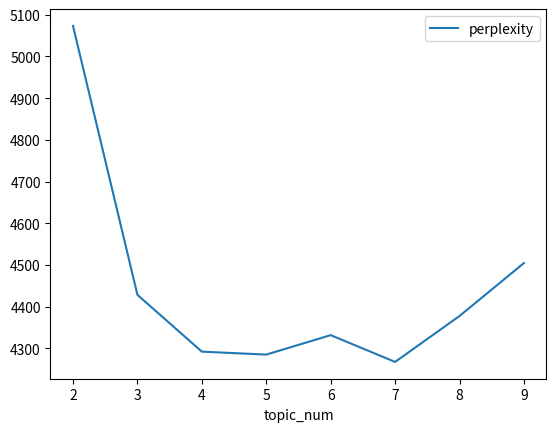

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

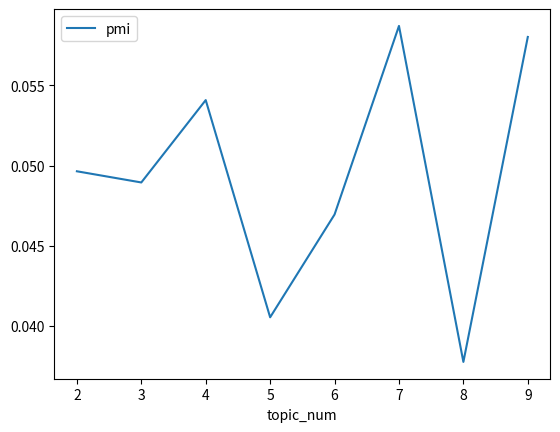

In [ ]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 到3之後逐漸降低。<br>
而coherence 最高則是7。

## 4. 視覺化呈現

**4.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 7 來做 LDAvis 的結果範例

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2023-05-08 02:40:18,374 : INFO : using symmetric alpha at 0.14285714285714285
2023-05-08 02:40:18,375 : INFO : using symmetric eta at 0.14285714285714285
2023-05-08 02:40:18,378 : INFO : using serial LDA version on this node
2023-05-08 02:40:18,397 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 7981 documents, updating model once every 2000 documents, evaluating perplexity every 7981 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-08 02:40:18,398 : INFO : PROGRESS: pass 0, at document #2000/7981
2023-05-08 02:40:19,779 : INFO : merging changes from 2000 documents into a model of 7981 documents
2023-05-08 02:40:19,787 : INFO : topic #6 (0.143): 0.009*"爆料" + 0.006*"表示" + 0.005*"報導" + 0.005*"網址" + 0.005*"按讚" + 0.005*"記者" + 0.005*"下載" + 0.005*"新聞網" + 0.004*"信箱" + 0.004*"壹蘋"
2023-05-08 02:40:19,788 : INFO : topic #0 (0.143): 0.013*"爆料" + 0.007*"下載" + 0.007*"壹蘋" + 0.006*"追蹤" + 0.006*"信箱" + 0.006*"新聞網" + 0.006*"按讚" +

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.191779 -0.015745       1        1  27.036320
2     -0.106125 -0.050878       2        1  24.420757
1      0.139588 -0.168741       3        1  20.682113
3     -0.154580 -0.099977       4        1   8.152974
5     -0.181024  0.114204       5        1   8.082508
6      0.188168  0.163923       6        1   5.934464
4     -0.077806  0.057214       7        1   5.690865, topic_info=      Term         Freq        Total Category  logprob  loglift
1665    中國  8606.000000  8606.000000  Default  30.0000  30.0000
20651  烏克蘭  2140.000000  2140.000000  Default  29.0000  29.0000
520    俄羅斯  1772.000000  1772.000000  Default  28.0000  28.0000
16130   立委  2998.000000  2998.000000  Default  27.0000  27.0000
5101   國民黨  3127.000000  3127.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
1357    影片   189.499813  1398.914858   Topic7  -6.0155   0.8672
353     表示   240.832192  9539.804363   Topic7  -5.7757  -0.8128
2102    使用   178.716641   980.092115   Topic7  -6.0740   1.1645
2109    國際   188.735751  2880.992222   Topic7  -6.0195   0.1408
149     成為   177.064996  1604.906396   Topic7  -6.0833   0.6620

[576 rows x 6 columns], token_table=       Topic      Freq Term
term                       
4084       1  0.025084   丈夫
4084       2  0.928095   丈夫
4084       3  0.010750   丈夫
4084       5  0.017917   丈夫
4084       7  0.014334   丈夫
...      ...       ...  ...
21271      3  0.998408   黨內
22469      3  0.995808   黨員
11435      1  0.003092   黨團
11435      3  0.995750   黨團
18412      3  0.997437   黨部

[1473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 6, 7, 5])

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## 5. 主題分佈的應用，搭配其他文章資訊

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(0, 0.016457165), (2, 0.97827107)]

In [ ]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.        , 0.19501752, ..., 0.        , 0.17877331,
        0.03541138],
       [0.13185698, 0.        , 0.        , ..., 0.09670858, 0.65390742,
        0.11555777],
       [0.        , 0.0156913 , 0.38903278, ..., 0.        , 0.43447489,
        0.        ],
       ...,
       [0.20158207, 0.        , 0.68706036, ..., 0.10453214, 0.        ,
        0.        ],
       [0.05843919, 0.70942777, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.17006326, 0.60096335, 0.18908897, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [ ]:
udn['topic_label'].value_counts()

topic_label
3    2540
1    2241
2    1441
4     593
6     536
5     331
7     299
Name: count, dtype: int64

In [ ]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,記者林丞偉台北報導新世代唱跳女團由利善榛裴頡連穎巴倫席淇組成適逢出道年前夕在台北三創舉辦首場...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 16:31:00,"[記者, 林丞偉, 台北, 報導, 新世代, 唱跳, 女團, 由利善, 裴頡連穎, 巴倫席,...",4
1,記者邱瓈瑩台北報導日本鐘錶品牌卡西歐繼日前宣布韓國女團成為旗下耐衝擊腕錶品牌大使藉此宣告加緊...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 22:57:00,"[記者, 台北, 報導, 日本, 鐘錶, 品牌, 卡西歐, 日前, 宣布, 韓國, 女團, ...",6
2,記者趙大智台北報導八大劇集奇蹟今日開鏡在俗女養成記季傳神演出同志弟弟的宋偉恩這次擺脫過往角色...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 19:17:00,"[記者, 大智, 台北, 報導, 八大, 劇集, 奇蹟, 今日, 開鏡, 俗女, 養成, 記...",6
3,記者張家玲台北報導月的第一天迎來了明媚的好天氣紐約時尚品牌也放送了好消息宣布女神舒淇成為品牌...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 16:20:00,"[記者, 張家, 台北, 報導, 第一天, 迎來, 明媚, 天氣, 紐約, 時尚, 品牌, ...",6
4,記者葉文正台北報導民視醫學大聯盟帶大家探討哪些行為有助於平衡免疫力改善整體健康節目日前邀請到...,https://tw.nextapple.com/entertainment/2023030...,娛樂時尚,2023-03-01 09:05:00,"[記者, 文正, 台北, 報導, 民視, 醫學, 大聯盟, 探討, 行為, 有助於, 平衡,...",3


In [ ]:
udn['artDate'] = pd.to_datetime(udn['artDate'])

In [ ]:
udn['artDate'].dt.date

0       2023-03-01
1       2023-03-01
2       2023-03-01
3       2023-03-01
4       2023-03-01
           ...    
7976    2023-04-29
7977    2023-04-29
7978    2023-04-29
7979    2023-04-29
7980    2023-04-29
Name: artDate, Length: 7981, dtype: object

In [ ]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2023-03-01  3              0.341463
            1              0.237805
            2              0.207317
            6              0.079268
            5              0.048780
                             ...   
2023-04-29  2              0.115385
            4              0.076923
            5              0.057692
            6              0.057692
            7              0.028846
Name: proportion, Length: 420, dtype: float64

In [ ]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6,7
artDate,,,,,,,
2023-03-01,0.237805,0.207317,0.341463,0.036585,0.048780,0.079268,0.048780
2023-03-02,0.296296,0.191358,0.327160,0.043210,0.030864,0.061728,0.049383
2023-03-03,0.195489,0.195489,0.368421,0.075188,0.067669,0.045113,0.052632
2023-03-04,0.203390,0.305085,0.305085,0.093220,0.033898,0.050847,0.008475
2023-03-05,0.217822,0.158416,0.356436,0.118812,0.049505,0.069307,0.029703


<Axes: xlabel='artDate'>

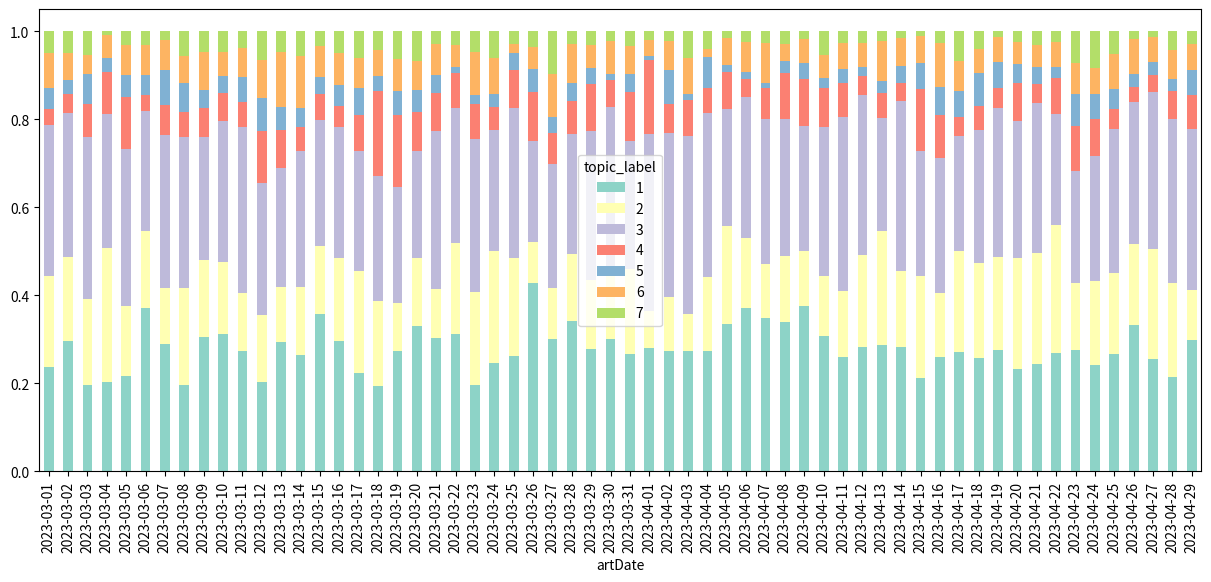

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

透過搭配文章的資訊（例如日期等），可以讓主題模型的結果做出更多的分析應用